In [ ]:
# Użycie zapisanych na dysku zdjęć.
!unzip -q '/content/drive/My Drive/train_val_test.zip' -d '/content'
# Load the TensorBoard notebook extension. #%reload_ext tensorboard
%load_ext tensorboard

In [ ]:
from numpy.random import seed
seed(1)
from tensorflow.random import set_seed
set_seed(2)

import os
import itertools
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, confusion_matrix

from tensorflow.keras import applications
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential, load_model, Model
from tensorflow.keras.layers import Dense, Conv2D, SeparableConv2D, Flatten, Dropout, MaxPooling2D, BatchNormalization, GlobalAveragePooling2D
from tensorflow.keras.callbacks import ModelCheckpoint, TensorBoard, EarlyStopping
from tensorflow.keras.optimizers import Adamax, Nadam, Ftrl, Adadelta
from tensorflow.keras.regularizers import l1_l2

BATCH_SIZE = 128
EPOCHS = 10
INITIAL_EPOCH = 0
IMG_HEIGHT, IMG_WIDTH, CHANNELS = 220, 220, 3

dir_path = "/content/train_val_test"
root = "/content/drive/My Drive/CNN_InceptionResNetV2/"

train_gen = ImageDataGenerator(rescale=1.0/255.)
val_gen = ImageDataGenerator(rescale=1.0/255.)
test_gen = ImageDataGenerator(rescale=1.0/255.)

train_generator = train_gen.flow_from_directory(
    dir_path + '/train',
    batch_size=BATCH_SIZE,
    shuffle=True,
    color_mode="rgb",
    class_mode='categorical',
    target_size=(IMG_HEIGHT, IMG_WIDTH),
    seed=2)
validation_generator = val_gen.flow_from_directory(
    dir_path + '/val',
    batch_size=BATCH_SIZE,
    shuffle=True,
    color_mode="rgb",
    class_mode='categorical',
    target_size=(IMG_HEIGHT, IMG_WIDTH),
    seed=2)
test_generator = test_gen.flow_from_directory(
    dir_path + '/test',
    batch_size=1,
    shuffle=False,
    color_mode="rgb",
    class_mode='categorical',
    target_size=(IMG_HEIGHT, IMG_WIDTH),
    seed=2)

STEP_SIZE_TRAIN = train_generator.n // train_generator.batch_size
STEP_SIZE_VALID = validation_generator.n // validation_generator.batch_size

my_callbacks = [
    ModelCheckpoint(filepath=root + "model.{epoch:02d}.h5",
                    monitor="val_accuracy",
                    mode='max',
                    save_best_only=True,
                    save_weights_only=False,
                    save_freq="epoch",),
    EarlyStopping(monitor="val_loss",
                  patience=5,),
    # TensorBoard(log_dir=root + "logs",
    #             write_images=True,
    #             histogram_freq=3,
    #             embeddings_freq=3),
]

Found 67628 images belonging to 5 classes.
Found 22615 images belonging to 5 classes.
Found 21883 images belonging to 5 classes.


In [ ]:
# Ustawienie wartości wag konkretnych klas podczas uczenia.
# Pozwala to wzmacniac straty (loss) wag dla tych klas.
target_names = sorted(os.listdir(dir_path + "/val"))
ref_nums = []
for i in target_names:
    ref_nums.append(len(os.listdir(dir_path + "/val/" + i)))

# ref_nums = [np.float16(max(ref_nums) / i) for i in ref_nums]
ref_nums = [np.float16(np.log2(max(ref_nums) / i) + 1) for i in ref_nums]
class_weight = dict(enumerate(ref_nums))
print(dict(zip(target_names, ref_nums)))

{'type_F': 5.33, 'type_N': 1.0, 'type_Q': 4.492, 'type_S': 5.902, 'type_V': 4.645}


In [ ]:
def plot_confusion_matrix(cm, target_names, title='Confusion matrix', cmap=None, normalize=True):
    accuracy = np.trace(cm) / float(np.sum(cm))
    misclass = 1 - accuracy

    if cmap is None:
        cmap = plt.get_cmap('Blues')

    plt.figure(figsize=(8, 6))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()

    if target_names is not None:
        tick_marks = np.arange(len(target_names))
        plt.xticks(tick_marks, target_names, rotation=45)
        plt.yticks(tick_marks, target_names)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    thresh = cm.max() / 1.5 if normalize else cm.max() / 2
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        if normalize:
            plt.text(j, i, "{:0.4f}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")
        else:
            plt.text(j, i, "{:,}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('Klasa predykowana')
    plt.xlabel('Klasa rzeczywista\naccuracy={:0.4f}; misclass={:0.4f}'.format(accuracy, misclass))
    plt.show()

In [ ]:
# Użycie zapisanego na dysku modelu.
files = [f for f in sorted(os.listdir(root))]
model_file = files[-1]
INITIAL_EPOCH = int(model_file.split('.')[1])
EPOCHS += INITIAL_EPOCH

model = load_model(root + model_file)
print(f"Wczytanie pliku modelu: {model_file}, z ilością EPOCH: {INITIAL_EPOCH}")

In [ ]:
# Wczytanie modelu ale bez ostatnich warstw by je podmienić
base_model = applications.InceptionResNetV2(weights= None, include_top=False, 
                                            input_shape=(IMG_HEIGHT, IMG_WIDTH, CHANNELS))
# Dodanie 2 warstw do wczytanego modelu, uwzględnienie liczbę klas
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dropout(0.7)(x)
predictions = Dense(5, activation= 'softmax')(x)
model = Model(inputs = base_model.input, outputs = predictions)

model.compile(optimizer=Adamax(learning_rate=0.001, 
                               beta_1=0.9, beta_2=0.999, 
                               epsilon=1e-07), 
              loss="categorical_crossentropy", 
              metrics=["accuracy"])

model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 220, 220, 3) 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 109, 109, 32) 864         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 109, 109, 32) 96          conv2d[0][0]                     
__________________________________________________________________________________________________
activation (Activation)         (None, 109, 109, 32) 0           batch_normalization[0][0]        
______________________________________________________________________________________________

In [ ]:
# Włączenie tensorboard.
%tensorboard --logdir "/content/drive/My Drive/CNN_InceptionResNetV2/logs" 

In [36]:
history = model.fit(train_generator, 
                    steps_per_epoch=STEP_SIZE_TRAIN,
                    validation_data=validation_generator,
                    validation_steps=STEP_SIZE_VALID,
                    epochs=EPOCHS, 
                    class_weight=class_weight,
                    shuffle=True,
                    callbacks=my_callbacks,
                    initial_epoch=INITIAL_EPOCH,
                    use_multiprocessing=False, verbose=1)

Epoch 1/10
528/528 [==============================] - 1318s 2s/step - loss: 0.0269 - accuracy: 0.9949 - val_loss: 0.0693 - val_accuracy: 0.9849
Epoch 2/10
528/528 [==============================] - 1325s 3s/step - loss: 0.0224 - accuracy: 0.9961 - val_loss: 0.0606 - val_accuracy: 0.9858
Epoch 3/10
528/528 [==============================] - 1327s 3s/step - loss: 0.0226 - accuracy: 0.9957 - val_loss: 0.0662 - val_accuracy: 0.9862
Epoch 4/10
528/528 [==============================] - 1319s 2s/step - loss: 0.0148 - accuracy: 0.9973 - val_loss: 0.0715 - val_accuracy: 0.9859
Epoch 5/10
528/528 [==============================] - 1318s 2s/step - loss: 0.0205 - accuracy: 0.9963 - val_loss: 0.0817 - val_accuracy: 0.9862
Epoch 6/10
528/528 [==============================] - 1318s 2s/step - loss: 0.0133 - accuracy: 0.9975 - val_loss: 0.0895 - val_accuracy: 0.9853
Epoch 7/10
528/528 [==============================] - 1319s 2s/step - loss: 0.0114 - accuracy: 0.9979 - val_loss: 0.0784 - val_accuracy:

In [37]:
# Sprawdzenie poprawności na danych testowych
test_generator.reset()
STEP_SIZE_TEST = test_generator.n // test_generator.batch_size 
scores = model.evaluate(test_generator, 
                        steps=STEP_SIZE_TEST,
                        verbose=0)
print(model.metrics_names[0] + " = ", scores[0])
print(model.metrics_names[1] + " = ", scores[1])

test_generator.reset()
probabilities = model.predict(test_generator, 
                              steps=STEP_SIZE_TEST,
                              verbose=0)
y_test = probabilities.argmax(axis=1)
y_pred = test_generator.classes
# target_names = sorted(os.listdir(dir_path + "/test"))
target_names = ["klasa F", "klasa N", "klasa Q", "klasa S", "klasa V"]
print(classification_report(y_test, y_pred, target_names=target_names))

loss =  0.07049679011106491
accuracy =  0.9829548001289368
              precision    recall  f1-score   support

     klasa F       0.89      0.94      0.91       151
     klasa N       0.99      0.99      0.99     17903
     klasa Q       1.00      1.00      1.00      1605
     klasa S       0.89      0.81      0.85       667
     klasa V       0.98      0.91      0.95      1557

    accuracy                           0.98     21883
   macro avg       0.95      0.93      0.94     21883
weighted avg       0.98      0.98      0.98     21883



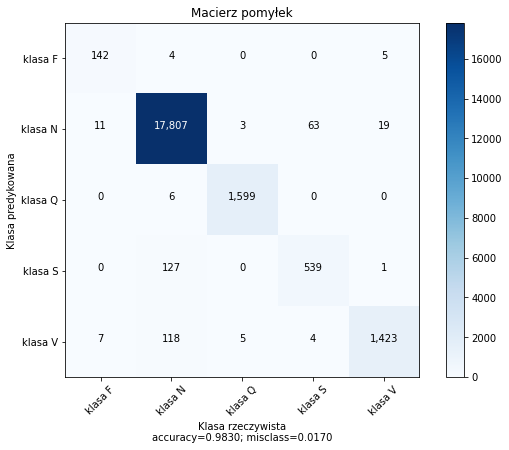

In [41]:
cm = confusion_matrix(y_test, y_pred)
plot_confusion_matrix(cm, target_names, title="Macierz pomyłek", cmap=None, normalize=False)

In [42]:
# Trenowanie na danych ze zbioru walidacyjnego.
model.fit(validation_generator, 
          steps_per_epoch=STEP_SIZE_VALID,
          epochs=2, 
          class_weight=class_weight,
          shuffle=True,
          use_multiprocessing=False, verbose=1)

# Sprawdzenie poprawności na danych testowych po trenowaniu na zbiorze walidacyjnym.
test_generator.reset()
STEP_SIZE_TEST = test_generator.n // test_generator.batch_size 
scores = model.evaluate(test_generator, 
                        steps=STEP_SIZE_TEST,
                        verbose=0)
print(model.metrics_names[0] + '=', scores[0])
print(model.metrics_names[1] + '=', scores[1])

test_generator.reset()
probabilities = model.predict(test_generator, 
                              steps=STEP_SIZE_TEST,
                              verbose=0)
y_test = probabilities.argmax(axis=1)
y_pred = test_generator.classes
# target_names = sorted(os.listdir(dir_path + "/test"))
target_names = ["klasa F", "klasa N", "klasa Q", "klasa S", "klasa V"]
print(classification_report(y_test, y_pred, target_names=target_names))

Epoch 1/2
176/176 [==============================] - 405s 2s/step - loss: 0.1777 - accuracy: 0.9782
Epoch 2/2
176/176 [==============================] - 398s 2s/step - loss: 0.0601 - accuracy: 0.9900
loss= 0.05411284416913986
accuracy= 0.9836859703063965
              precision    recall  f1-score   support

     klasa F       0.94      0.76      0.84       200
     klasa N       0.99      0.99      0.99     17934
     klasa Q       0.99      1.00      1.00      1597
     klasa S       0.91      0.76      0.82       726
     klasa V       0.97      0.98      0.97      1426

    accuracy                           0.98     21883
   macro avg       0.96      0.90      0.93     21883
weighted avg       0.98      0.98      0.98     21883



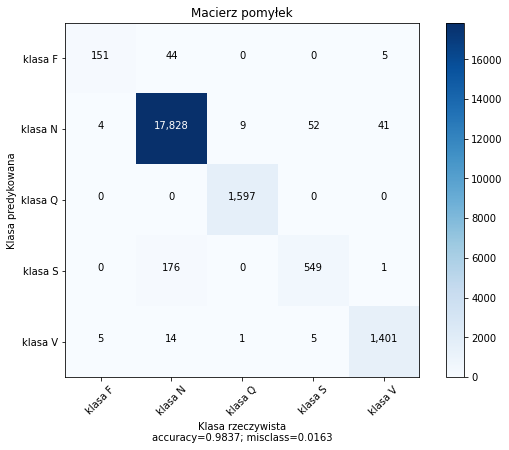

In [44]:
cm = confusion_matrix(y_test, y_pred)
plot_confusion_matrix(cm, target_names, title="Macierz pomyłek", cmap=None, normalize=False)

In [43]:
# Zapisanie pliku .csv porównując typ i predykcję, jest podane zdjęcie więc łatwo będzie sprawdzić co z nim nie tak
test_generator.reset()
probabilities = model.predict(test_generator, 
                              steps=STEP_SIZE_TEST,
                              verbose=1)
predicted_class_indices = np.argmax(probabilities, axis=1)
labels = (train_generator.class_indices)
labels = dict((v, k) for k, v in labels.items())
predictions = [labels[k] for k in predicted_class_indices]

filenames = test_generator.filenames
results=pd.DataFrame({"Filename": filenames,
                      "Predictions": predictions,})
results.to_csv("results.csv", sep=';', index=False)

21883/21883 [==============================] - 527s 24ms/step


In [46]:
# Zapisanie modelu do pliku
model.save('model_epoch17train_epoch2val.h5')

In [ ]:
# Tworzenie schematu zawierającego kształt warstw.
from keras.utils import plot_model
plot_model(base_model, show_shapes=True, to_file="model.png")